In [1]:
import numpy as np
import pandas as pd
import os
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn import metrics
from collections import Counter
from imblearn.over_sampling import ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tkinter as tk

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)


In [2]:
data = pd.read_csv('UCI_Credit_Card.csv')
df = data.copy()

- Load the dataset

## Quick Look at the Data Structure

In [3]:
df.shape

(30000, 25)

- Dataset contains 30,000 rows and 25 columns

In [4]:
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
new_col = ['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_Sep05',
 'PAY_Aug05',
 'PAY_Jul05',
 'PAY_Jun05',
 'PAY_May05',
 'PAY_Apr05',
 'BILL_AMT_Sep05',
 'BILL_AMT_Aug05',
 'BILL_AMT_Jul05',
 'BILL_AMT_Jun05',
 'BILL_AMT_May05',
 'BILL_AMT_Apr05',
 'PAY_AMT_Sep05',
 'PAY_AMT_Aug05',
 'PAY_AMT_Jul05',
 'PAY_AMT_Jun05',
 'PAY_AMT_May05',
 'PAY_AMT_Apr05',
 'default.payment.next.month']

In [6]:
df.columns = new_col

- Rename column names to corresponding month/year

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_Sep05                   30000 non-null  int64  
 7   PAY_Aug05                   30000 non-null  int64  
 8   PAY_Jul05                   30000 non-null  int64  
 9   PAY_Jun05                   30000 non-null  int64  
 10  PAY_May05                   30000 non-null  int64  
 11  PAY_Apr05                   30000 non-null  int64  
 12  BILL_AMT_Sep05              30000 non-null  float64
 13  BILL_AMT_Aug05              300

- No missing values
- Data types all correct
- All input values are numerical

In [8]:
df['ID'].duplicated().sum()

0

In [9]:
df = df.drop('ID', axis=1)

- 'ID' column is rather an index than client identification. Dropped.

In [10]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_Sep05,PAY_Aug05,PAY_Jul05,PAY_Jun05,PAY_May05,PAY_Apr05,BILL_AMT_Sep05,BILL_AMT_Aug05,BILL_AMT_Jul05,BILL_AMT_Jun05,BILL_AMT_May05,BILL_AMT_Apr05,PAY_AMT_Sep05,PAY_AMT_Aug05,PAY_AMT_Jul05,PAY_AMT_Jun05,PAY_AMT_May05,PAY_AMT_Apr05,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


- Summary of each numerical feature

In [11]:
{column: len(df[column].unique()) for column in df.columns}

{'LIMIT_BAL': 81,
 'SEX': 2,
 'EDUCATION': 7,
 'MARRIAGE': 4,
 'AGE': 56,
 'PAY_Sep05': 11,
 'PAY_Aug05': 11,
 'PAY_Jul05': 11,
 'PAY_Jun05': 11,
 'PAY_May05': 10,
 'PAY_Apr05': 10,
 'BILL_AMT_Sep05': 22723,
 'BILL_AMT_Aug05': 22346,
 'BILL_AMT_Jul05': 22026,
 'BILL_AMT_Jun05': 21548,
 'BILL_AMT_May05': 21010,
 'BILL_AMT_Apr05': 20604,
 'PAY_AMT_Sep05': 7943,
 'PAY_AMT_Aug05': 7899,
 'PAY_AMT_Jul05': 7518,
 'PAY_AMT_Jun05': 6937,
 'PAY_AMT_May05': 6897,
 'PAY_AMT_Apr05': 6939,
 'default.payment.next.month': 2}

- Check unique values in each column

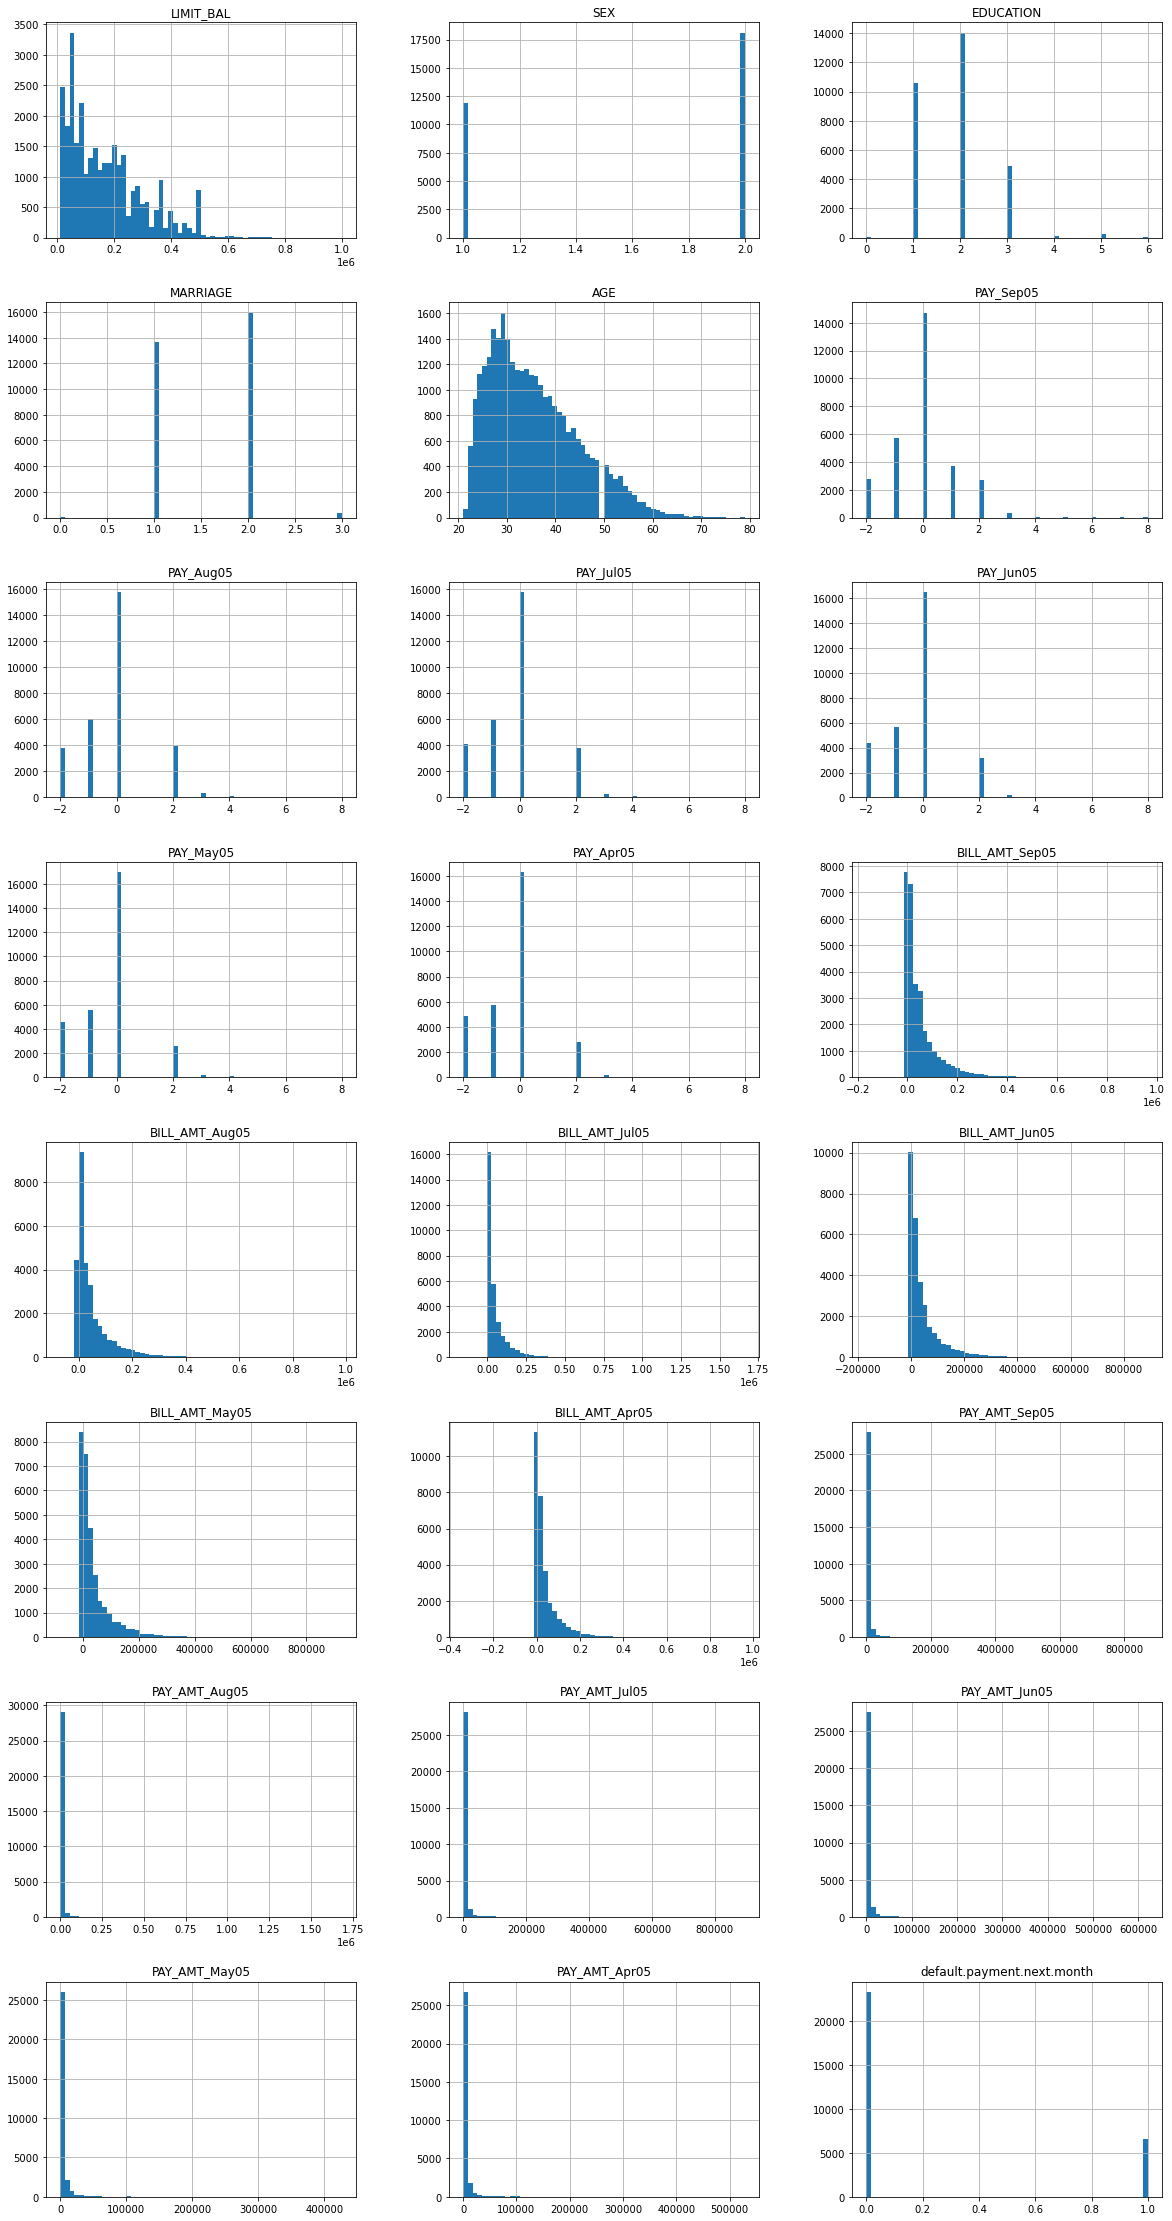

In [12]:
df.hist(bins=60, layout=(8,3), figsize=(20,40))
plt.show();

- A quick look at the distribution of input values of all features

## Creating training data set for data exploration

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

- Create train and test set

In [14]:
df_train['default.payment.next.month'].value_counts()/len(df_train)

0    0.778208
1    0.221792
Name: default.payment.next.month, dtype: float64

In [15]:
df_test['default.payment.next.month'].value_counts()/len(df_test)

0    0.781167
1    0.218833
Name: default.payment.next.month, dtype: float64

- Verify the test set is representative of training set
- Data with class imbalance issue

## Data Discovery & Visualization

In [ ]:
#ProfileReport(df_train)

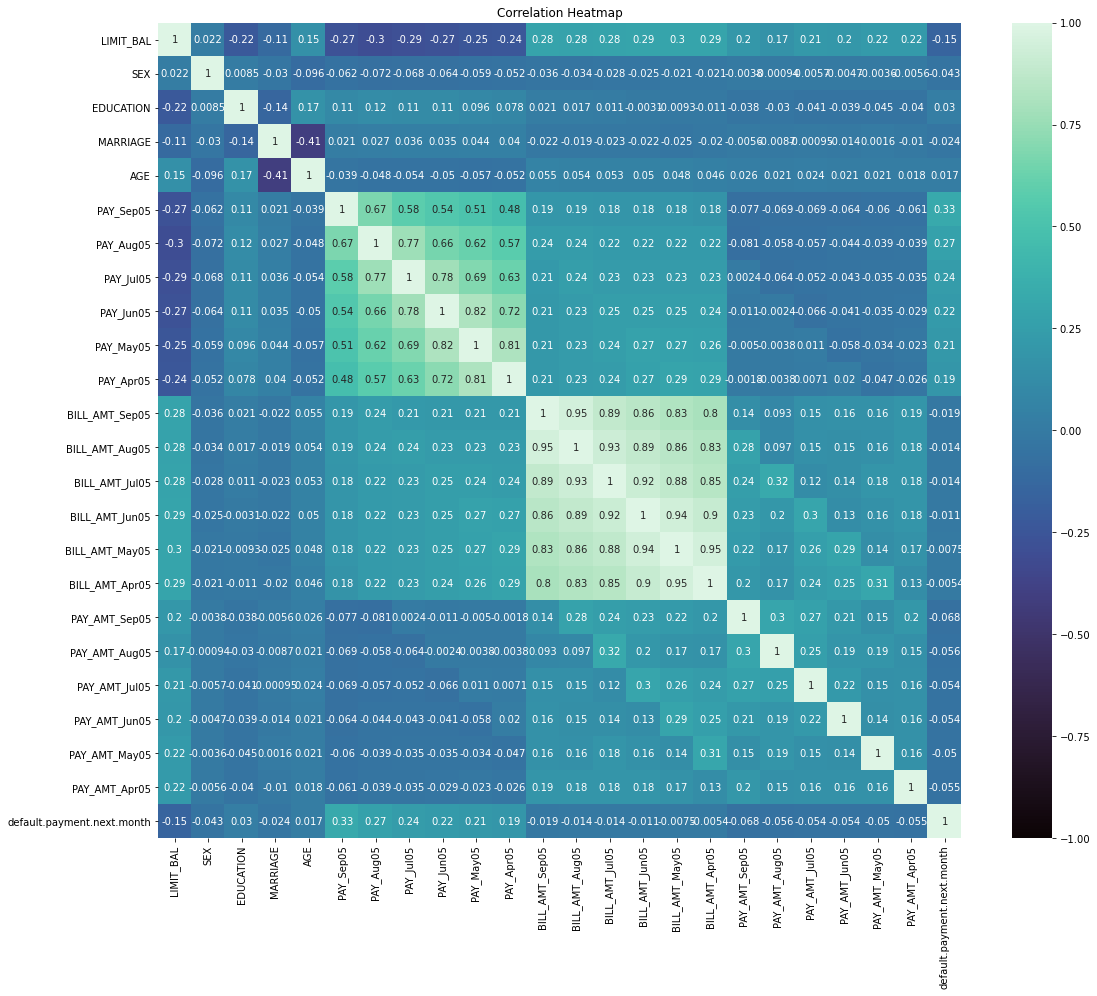

In [16]:
corr = df_train.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show();

- High correlation among the monthly payment records and amounts of bill

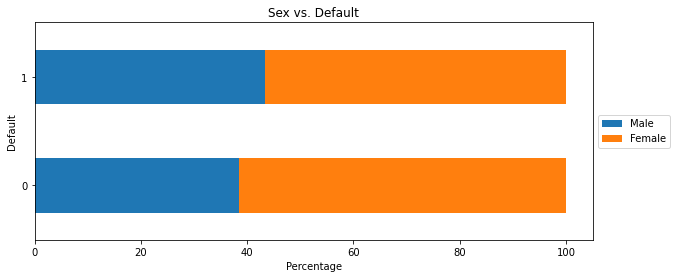

In [17]:
df_plot = df_train.groupby(['default.payment.next.month', 'SEX'])['SEX'].count().to_frame('Count').reset_index()
df_plot = pd.pivot_table(df_plot, values='Count', index=['default.payment.next.month'], columns='SEX')
df_plot.columns = ['Male', 'Female']

df_plot['Sum'] = df_plot['Male'] + df_plot['Female']
df_plot['Male'] = df_plot['Male'] / df_plot['Sum'] * 100
df_plot['Female'] = df_plot['Female'] / df_plot['Sum'] * 100
df_plot = df_plot.drop('Sum', axis=1)

df_plot.plot(kind='barh', stacked=True, figsize=(10,4))
plt.xlabel('Percentage')
plt.ylabel('Default')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Sex vs. Default')
plt.show();

- Higher percentage of male with the clients with default records, but not significantly more

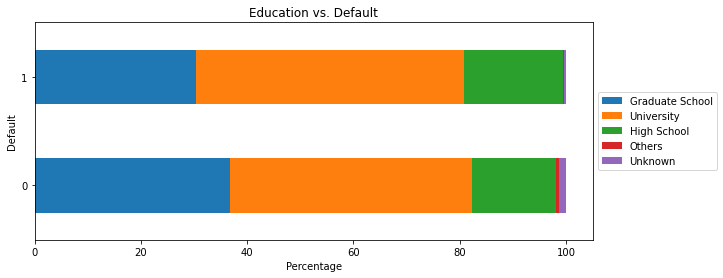

In [18]:
df_plot = df_train.groupby(['default.payment.next.month', 'EDUCATION'])['EDUCATION'].count().to_frame('Count').reset_index()
df_plot = pd.pivot_table(df_plot, values='Count', index=['default.payment.next.month'], columns='EDUCATION')
df_plot = df_plot.fillna(0)
df_plot['Unknown'] = df_plot[0] + df_plot[5] + df_plot[6]
df_plot = df_plot.drop([0, 5, 6], axis=1)
df_plot['Sum'] = df_plot[list(df_plot.columns)].sum(axis=1)
df_plot.columns = ['Graduate School', 'University', 'High School', 'Others', 'Unknown', 'Sum']

df_plot['Graduate School'] = df_plot['Graduate School'] / df_plot['Sum'] * 100
df_plot['University'] = df_plot['University'] / df_plot['Sum'] * 100
df_plot['High School'] = df_plot['High School'] / df_plot['Sum'] * 100
df_plot['Others'] = df_plot['Others'] / df_plot['Sum'] * 100
df_plot['Unknown'] = df_plot['Unknown'] / df_plot['Sum'] * 100
df_plot = df_plot.drop('Sum', axis=1)

df_plot.plot(kind='barh', stacked=True, figsize=(10,4))
plt.xlabel('Percentage')
plt.ylabel('Default')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Education vs. Default')
plt.show();

- No significant difference in the distribution of education level between the client groups with and without default record
- The percentage of clients with univeristy degree is slgihtly higher with the client group with default record

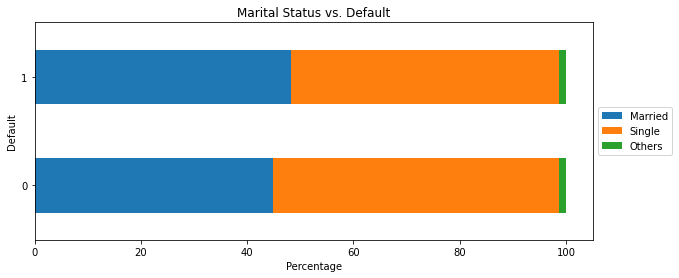

In [19]:
df_plot = df_train.groupby(['default.payment.next.month', 'MARRIAGE'])['MARRIAGE'].count().to_frame('Count').reset_index()
df_plot = pd.pivot_table(df_plot, values='Count', index=['default.payment.next.month'], columns='MARRIAGE')
df_plot['Others'] = df_plot[0] + df_plot[3]
df_plot = df_plot.drop([0, 3], axis=1)
df_plot['Sum'] = df_plot[list(df_plot.columns)].sum(axis=1)
df_plot.columns = ['Married', 'Single', 'Others', 'Sum']

df_plot['Married'] = df_plot['Married'] / df_plot['Sum'] * 100
df_plot['Single'] = df_plot['Single'] / df_plot['Sum'] * 100
df_plot['Others'] = df_plot['Others'] / df_plot['Sum'] * 100
df_plot = df_plot.drop('Sum', axis=1)

df_plot.plot(kind='barh', stacked=True, figsize=(10,4))
plt.xlabel('Percentage')
plt.ylabel('Default')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Marital Status vs. Default')
plt.show();

- Marital status doesn't seem to play a significant role in credit card default either
- Married clients are slightly more likely to default

## Data Engineering

### New Feature: Credit Line Usage

In [20]:
months = ['Sep05', 'Aug05', 'Jul05', 'Jun05', 'May05', 'Apr05']

def credit_line_usage(df, months):
    for month in months:
        df['Credit_Use_%_'+month] = (df['BILL_AMT_'+month] / df['LIMIT_BAL'])*100
    return df

df = credit_line_usage(df, months)

- A new feature 'Credit_Use_%' created for each month, which is the percentage of amount spent to total credit limit amount

### New Feature: Total Number of Months with Delayed Payment

In [21]:
df['Delay_Months'] = 0

for month in months:
    df['Delay_Months']= df['Delay_Months'] + df['PAY_'+month].apply(lambda x:1 if x > 0 else 0)

- A new feature 'Delay_Months' create, which is the number of months with delayed payment

### New Feature: Payment Delay

In [22]:
df['Payment_Delay'] = df['Delay_Months'].apply(lambda x:1 if x > 0 else 0)

- A new feature 'Payment_Delay' created
- This is a 1/0 flag, indicating whether individual client has ever had delayed payments. If no delay payments at all, then 0 is given, otherwise 1

### Preparing Data for Training

In [23]:
def onehot_encode(df, column_dict):
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([column, prefix+'_0'], axis=1)
    return df

def preprocess_inputs(df):
    
    # Onehot encode
    df = onehot_encode(
        df,
        {
            'EDUCATION': 'EDU',
            'MARRIAGE': 'MAR'
        }
    )
    
    # Split df into X and y
    X = df.drop('default.payment.next.month', axis=1)
    y = df['default.payment.next.month']
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Use ADASYN to solve the imbalance issue of the data
    ada = ADASYN(random_state=42)
    X, y = ada.fit_resample(X,y)
    
    # Split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, y_train, X_test, y_test

- Preprocessing data:
    1. Create dummy variables for 'EDUCATION' and 'MARRIAGE' features
    2. Split dataset into data X and target label y
    3. Scale data features with standard scaler
    4. Split X and y for training and testing

In [24]:
X_train, y_train, X_test, y_test = preprocess_inputs(df)

- Create training and testing data

In [25]:
corr_matrix = X_train.corr()

corr_matrix['Delay_Months'].sort_values(ascending=False)

Delay_Months          1.000000
Payment_Delay         0.747216
PAY_Aug05             0.686338
PAY_Jul05             0.678667
PAY_Jun05             0.659456
PAY_Sep05             0.651825
PAY_May05             0.637779
PAY_Apr05             0.594285
Credit_Use_%_Apr05    0.317244
Credit_Use_%_May05    0.306961
Credit_Use_%_Jun05    0.273639
Credit_Use_%_Jul05    0.223004
Credit_Use_%_Aug05    0.191163
Credit_Use_%_Sep05    0.161690
BILL_AMT_Apr05        0.062436
BILL_AMT_May05        0.055650
EDU_3                 0.053052
EDU_2                 0.051306
BILL_AMT_Jun05        0.037481
BILL_AMT_Jul05        0.014879
MAR_1                 0.002094
BILL_AMT_Aug05        0.000313
MAR_3                -0.001151
MAR_2                -0.001815
BILL_AMT_Sep05       -0.016156
EDU_6                -0.020610
AGE                  -0.024686
EDU_4                -0.027878
SEX                  -0.036642
EDU_5                -0.037638
PAY_AMT_Apr05        -0.067557
PAY_AMT_Aug05        -0.068472
PAY_AMT_

In [26]:
corr_matrix['Payment_Delay'].sort_values(ascending=False)

Payment_Delay         1.000000
Delay_Months          0.747216
PAY_Sep05             0.645474
PAY_Aug05             0.449605
PAY_Jul05             0.443608
PAY_Jun05             0.394254
PAY_Apr05             0.365906
PAY_May05             0.362454
Credit_Use_%_Apr05    0.195683
Credit_Use_%_May05    0.191067
Credit_Use_%_Jun05    0.165050
Credit_Use_%_Jul05    0.124015
Credit_Use_%_Aug05    0.098042
Credit_Use_%_Sep05    0.065073
EDU_3                 0.045116
EDU_2                 0.019730
MAR_2                 0.006262
MAR_3                 0.001832
MAR_1                -0.006365
BILL_AMT_Apr05       -0.015623
BILL_AMT_May05       -0.018561
SEX                  -0.019646
EDU_4                -0.027069
EDU_6                -0.027546
AGE                  -0.030651
BILL_AMT_Jun05       -0.034633
EDU_5                -0.038261
EDU_1                -0.043778
BILL_AMT_Jul05       -0.052317
BILL_AMT_Aug05       -0.064635
PAY_AMT_Aug05        -0.078941
PAY_AMT_Jul05        -0.082148
BILL_AMT

- The 2 new features 'Delay_Months' and 'Payment_Delay' both seem to positively correlated with 'PAY_' features

## Model Trainig and Prediction

3 Machine Learning Models used to train the data:
- Logistic Regression
- Random Forest
- XGBoost Classifier

### Logistic Regression

In [27]:
log = LogisticRegression(solver='lbfgs')

#### Grid Search

In [28]:
param_grid = [{'C':[0.1, 1, 10, 100], 'max_iter': [1000, 2000, 3000]}]
grid_search = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'max_iter': [1000, 2000, 3000]}],
             return_train_score=True, scoring='roc_auc')

In [29]:
grid_search.best_params_

{'C': 100, 'max_iter': 1000}

In [30]:
curves = grid_search.cv_results_
for mean_score, params in zip(curves['mean_test_score'], curves['params']):
    print(mean_score, params)

0.7185731605931801 {'C': 0.1, 'max_iter': 1000}
0.7185731605931801 {'C': 0.1, 'max_iter': 2000}
0.7185731605931801 {'C': 0.1, 'max_iter': 3000}
0.7186632872588804 {'C': 1, 'max_iter': 1000}
0.7186632872588804 {'C': 1, 'max_iter': 2000}
0.7186632872588804 {'C': 1, 'max_iter': 3000}
0.7186647012509704 {'C': 10, 'max_iter': 1000}
0.7186647012509704 {'C': 10, 'max_iter': 2000}
0.7186647012509704 {'C': 10, 'max_iter': 3000}
0.7186695470995775 {'C': 100, 'max_iter': 1000}
0.7186695470995775 {'C': 100, 'max_iter': 2000}
0.7186695470995775 {'C': 100, 'max_iter': 3000}


In [31]:
log = LogisticRegression(solver='lbfgs', C=100, max_iter=1000)
log.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000)

In [32]:
y_pred = log.predict(X_test)

In [33]:
cross_val_score(log, X_train, y_train, cv=5, scoring="accuracy")

array([0.65934066, 0.667752  , 0.65839099, 0.66096866, 0.65282865])

In [ ]:
# skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# for train_index, test_index in skfolds.split(X_train, y_train):
#     clone_clf = clone(log)
#     X_train_folds = X_train.iloc[train_index]
#     y_train_folds = y_train.iloc[train_index]
#     X_test_fold = X_train.iloc[test_index]
#     y_test_fold = y_train.iloc[test_index]

#     clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
#     n_correct = sum(y_pred == y_test_fold)
#     print(n_correct / len(y_pred))

- Measuring accuracy using cross-validation

In [34]:
y_train_pred = cross_val_predict(log, X_train, y_train, cv=5)

def plot_confusion(prediction):
    conmat = np.array(confusion_matrix(y_train, prediction, labels=[0, 1]))
    confusion = pd.DataFrame(conmat, index=['not default', 'default'],
                            columns = ['predicted not default', 'predicted default'])
    print(confusion)

plot_confusion(y_train_pred)

             predicted not default  predicted default
not default                  14412               4340
default                       8196               9907


- Plotting confusion matrix

In [35]:
print('Precision Score: ', precision_score(y_train, y_train_pred))
print('Recall Score: ', recall_score(y_train, y_train_pred))
print('F1 Score: ', f1_score(y_train, y_train_pred))

Precision Score:  0.695374464799607
Recall Score:  0.5472573606584544
F1 Score:  0.6124884080370944


- Checking measuring scores. Recall score quite low

In [36]:
y_scores = cross_val_predict(log, X_train, y_train, cv=5, method='decision_function')

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True) 
    plt.axis([-3, 2, 0, 1]) 

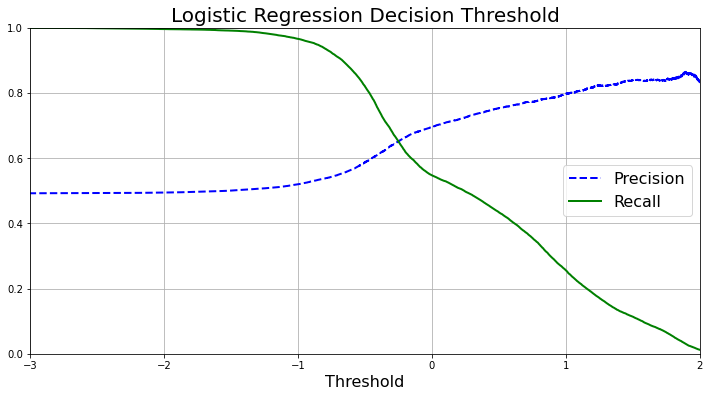

In [39]:
plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Logistic Regression Decision Threshold', fontsize=20)
plt.show();

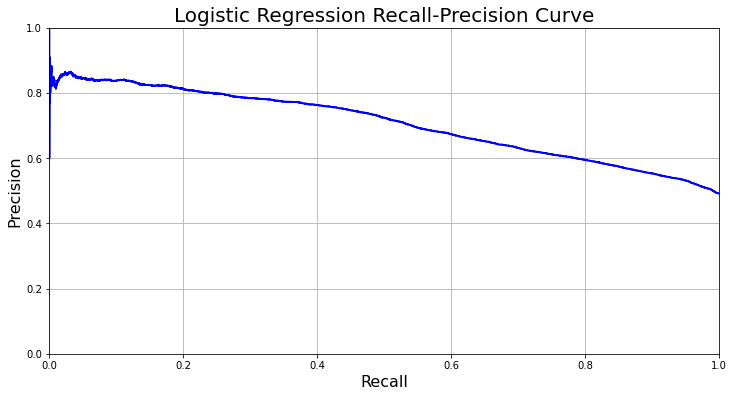

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(12, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('Logistic Regression Recall-Precision Curve', fontsize=20)
plt.show()

In [41]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

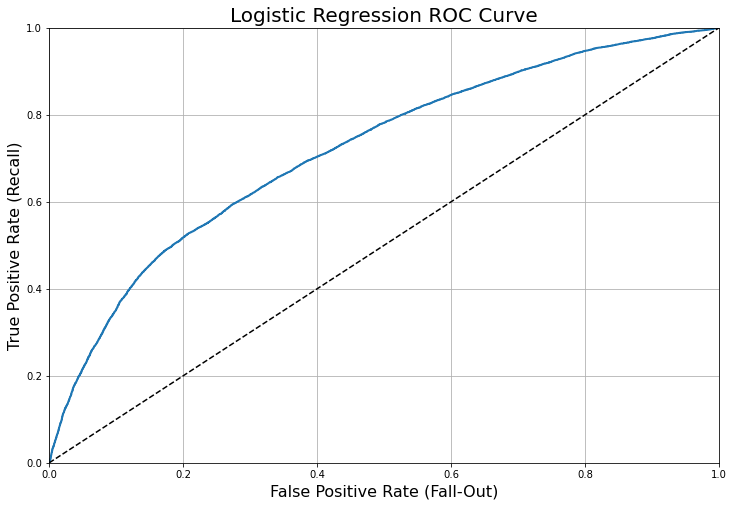

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(12, 8))                          
plot_roc_curve(fpr, tpr)             
plt.title('Logistic Regression ROC Curve',fontsize=20)
plt.show();

In [43]:
print('Logistic Regression ROC-AUC:', roc_auc_score(y_train, y_scores))

Logistic Regression ROC-AUC: 0.7185870565454144


### Random Forest

In [44]:
rf = RandomForestClassifier()

#### Grid Search

In [ ]:
# param_grid = [{'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [30, 50],
#  'n_estimators': [200, 400]}]

# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_params_

In [ ]:
# curves = grid_search.cv_results_
# for mean_score, params in zip(curves['mean_test_score'], curves['params']):
#     print(mean_score, params)

In [45]:
rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', min_samples_leaf=30)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=30,
                       n_estimators=200)

In [46]:
cross_val_score(rf, X_train, y_train, cv=5, scoring="accuracy")

array([0.76312576, 0.7678741 , 0.76109076, 0.75172975, 0.75349342])

In [47]:
y_train_pred = cross_val_predict(rf, X_train, y_train, cv=5)

def plot_confusion(prediction):
    conmat = np.array(confusion_matrix(y_train, prediction, labels=[0, 1]))
    confusion = pd.DataFrame(conmat, index=['not default', 'default'],
                            columns = ['predicted not default', 'predicted default'])
    print(confusion)

plot_confusion(y_train_pred)

             predicted not default  predicted default
not default                  15201               3551
default                       5298              12805


In [48]:
print('Precision Score:', precision_score(y_train, y_train_pred))
print('Recall Score:', recall_score(y_train, y_train_pred))
print('F1 Score:', f1_score(y_train, y_train_pred))

Precision Score: 0.782893127904133
Recall Score: 0.7073413246423245
F1 Score: 0.7432020662236282


In [49]:
y_probas = cross_val_predict(rf, X_train, y_train, cv=5, method='predict_proba')

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probas[:,1])

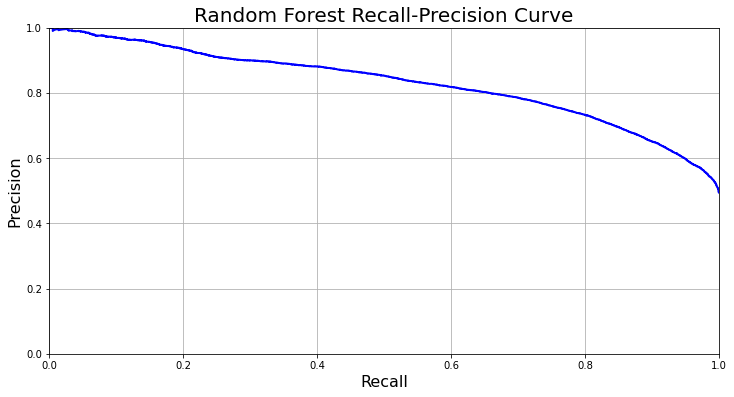

In [51]:
plt.figure(figsize=(12, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('Random Forest Recall-Precision Curve', fontsize=20)
plt.show();

In [52]:
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:,1])

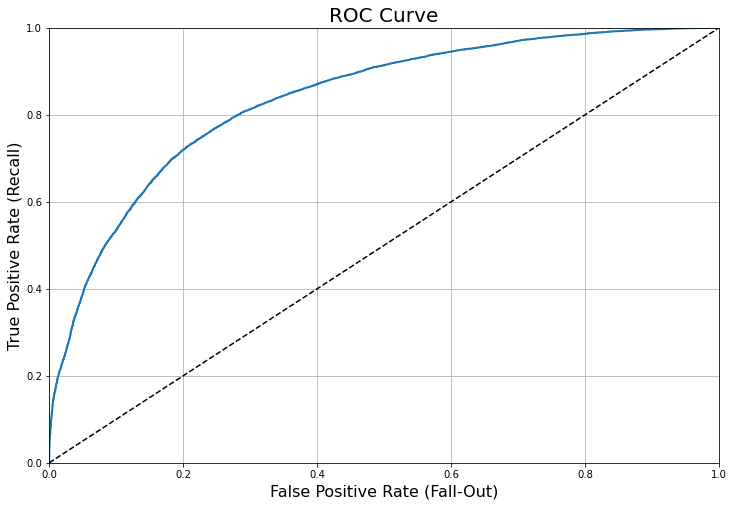

In [53]:
plt.figure(figsize=(12, 8))                          
plot_roc_curve(fpr, tpr)             
plt.title('Random Forest ROC Curve',fontsize=20)
plt.show();

In [54]:
print('Random Forest ROC-AUC:', roc_auc_score(y_train, y_probas[:,1]))

ROC-AUC: 0.8364317196874389


In [ ]:
# rf.score(X_test, y_test)

In [ ]:
# y_test_pred = cross_val_predict(rf, X_test, y_test, cv=5)

In [ ]:
# print('Precision Score:', precision_score(y_test, y_test_pred))
# print('Recall Score:', recall_score(y_test, y_test_pred))
# print('F1 Score:', f1_score(y_test, y_test_pred))

In [ ]:
# def plot_confusion(prediction):
#     conmat = np.array(confusion_matrix(y_test, prediction, labels=[0, 1]))
#     confusion = pd.DataFrame(conmat, index=['not default', 'default'],
#                             columns = ['predicted not default', 'predicted default'])
#     print(confusion)

# plot_confusion(y_test_pred)

### Support Vector Machine

In [55]:
svm = SVC()

In [57]:
# param_grid = [{'kernel': ['poly', 'rbf'],
#  'C': [0.1, 1, 10, 100],
#  'gamma': ['scale', 'auto']}]

# grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='roc_auc', return_train_score=True)
# grid_search.fit(X_train, y_train)

In [ ]:
# grid_search.best_params_

In [ ]:
# curves = grid_search.cv_results_
# for mean_score, params in zip(curves['mean_test_score'], curves['params']):
#     print(mean_score, params)

In [58]:
svm.fit(X_train, y_train)

SVC()

In [ ]:
cross_val_score(svm, X_train, y_train, cv=5, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(svm, X_train, y_train, cv=5)

def plot_confusion(prediction):
    conmat = np.array(confusion_matrix(y_train, prediction, labels=[0, 1]))
    confusion = pd.DataFrame(conmat, index=['not default', 'default'],
                            columns = ['predicted not default', 'predicted default'])
    print(confusion)

plot_confusion(y_train_pred)

In [ ]:
print('Precision Score:', precision_score(y_train, y_train_pred))
print('Recall Score:', recall_score(y_train, y_train_pred))
print('F1 Score:', f1_score(y_train, y_train_pred))

In [ ]:
y_probas = cross_val_predict(svm, X_train, y_train, cv=5, method='predict_proba')

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probas[:,1])

In [ ]:
plt.figure(figsize=(12, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('Support Vector Machine Recall-Precision Curve', fontsize=20)
plt.show();

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:,1])

In [ ]:
plt.figure(figsize=(12, 8))                          
plot_roc_curve(fpr, tpr)             
plt.title('Support Vector Machine ROC Curve',fontsize=20)
plt.show();

In [ ]:
print('Support Vector Machine ROC-AUC:', roc_auc_score(y_train, y_probas[:,1]))

In [ ]:
df.head(0)